In [ ]:
from pathlib import Path
import pandas as pd
import warnings; warnings.simplefilter("ignore", RuntimeWarning)
    
DATA_DIR = Path("~/Coding/hill-of-towie-wind-turbine/data/")
OUTPUT_DIR = Path("~/Coding/hill-of-towie-wind-turbine/data/output")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train_data_fpath = DATA_DIR / "train" / "training_dataset.parquet"
submission_data_fpath = DATA_DIR / "test" / "submission_dataset.parquet"

In [2]:
TARGET_COL = "target"

class Cols:
    """Class to hold the column names of the dataset. Which allows for tab-completion and minimizes typos."""

    TIMESTAMP = "TimeStamp_StartFormat"
    TURBINE_ID = "turbine_id"
    WINDSPEED_MEAN = "wtc_AcWindSp_mean"
    ACTIVEPOWER_MEAN = "wtc_ActPower_mean"
    OP_TIMEON = "wtc_ScReToOp_timeon"
    SHUTDOWN_DURATION = "ShutdownDuration"

# Loading the data
The data can be loaded into memory using pandas's `read_parquet` method.

As Kaggle requires a unique `id` first column to be used in the submission, the data already contains one, which we can set as the index.
The value is just the number of 10-minute timestamps since the start of the submission dataset start (so it will be negative values in the training dataset).

In [3]:
input_df = pd.read_parquet(train_data_fpath)
input_df.head(3)

,TimeStamp_StartFormat,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,...,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid,target
0,2016-01-01 00:00:00+00:00,6.085917,5.830675,6.613091,6.998510,7.645727,7.040790,2.0,1.1,1.6,...,976.166321,0.0,6.080296,10.040418,233.695404,236.784729,13.0,-210384,True,352.522308
1,2016-01-01 00:10:00+00:00,5.824693,5.810768,5.895642,6.521900,6.413868,6.599652,2.1,2.2,1.9,...,982.179504,100.0,3.301515,6.958448,178.264328,187.431320,6.9,-210383,True,294.078888
2,2016-01-01 00:20:00+00:00,7.100180,6.386981,7.606015,7.695034,7.812548,7.469052,2.2,2.1,0.0,...,985.240540,78.0,3.478505,4.648656,198.435043,198.824799,7.7,-210382,True,587.302795


# Data Preparation

Splitting the training data into a training subset (70%) and a test subset (30%)
so we can check our model performance on unseen data (the test set).

As the target turbine is Turbine 1, the feature columns will be all the data from turbines other than the target one.

The target column has already been created and it is called `target`.

In [4]:
test_fraction = 0.3
ts_min, ts_max = input_df[Cols.TIMESTAMP].min(), input_df[Cols.TIMESTAMP].max()
test_subset_start = ts_min + (ts_max - ts_min) * (1 - test_fraction)
is_train_subset = input_df[Cols.TIMESTAMP] < test_subset_start

feature_cols = [i for i in input_df.columns if not i.endswith(";1") and i != TARGET_COL]


def _split_into_X_y(d: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    return d[feature_cols], d[TARGET_COL].mask(~d["is_valid"])


X_train, y_train = input_df[is_train_subset].pipe(_split_into_X_y)
X_test, y_test = input_df[~is_train_subset].pipe(_split_into_X_y)

In [5]:
display(X_train.head(3))
display(y_train.head(3))

,TimeStamp_StartFormat,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,...,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid
0,2016-01-01 00:00:00+00:00,5.830675,6.613091,6.998510,7.645727,7.040790,1.1,1.6,2.4,4.3,...,0.0,976.166321,0.0,6.080296,10.040418,233.695404,236.784729,13.0,-210384,True
1,2016-01-01 00:10:00+00:00,5.810768,5.895642,6.521900,6.413868,6.599652,2.2,1.9,2.2,2.3,...,0.0,982.179504,100.0,3.301515,6.958448,178.264328,187.431320,6.9,-210383,True
2,2016-01-01 00:20:00+00:00,6.386981,7.606015,7.695034,7.812548,7.469052,2.1,0.0,4.2,4.0,...,0.0,985.240540,78.0,3.478505,4.648656,198.435043,198.824799,7.7,-210382,True


0    352.522308
1    294.078888
2    587.302795
Name: target, dtype: float64

In [6]:
display(X_test.head(3))
display(y_test.head(3))

,TimeStamp_StartFormat,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,...,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid
147269,2018-10-19 16:50:00+00:00,7.048638,9.044636,6.810880,4.872089,9.327437,3.51,5.80,3.43,2.20,...,0.5,987.273315,77.0,4.792703,8.645230,203.355576,209.826996,10.6,-63115,True
147270,2018-10-19 17:00:00+00:00,6.400766,8.420758,6.259468,4.354299,8.992995,2.69,4.73,3.26,1.79,...,0.0,991.590149,38.0,3.701351,6.519202,271.548126,274.398621,8.6,-63114,True
147271,2018-10-19 17:10:00+00:00,5.183845,7.542589,4.765704,4.695193,8.731892,2.53,4.57,2.04,1.96,...,0.0,994.320801,100.0,2.000000,4.492216,180.000000,196.821487,4.0,-63113,True


147269    701.983826
147270    631.159119
147271    425.913208
Name: target, dtype: float64

# Define the model
We'll use a simple model that just takes the estimates the Active Power of the target
turbine as the average of the Active Power of all other fully-operating turbines.

In [7]:
FULL_10MIN = 600  # full counter value for 10min interval
other_turbines_ids = [2, 3, 4, 5, 7]
other_turbines_power_cols = [f"{Cols.ACTIVEPOWER_MEAN};{i}" for i in other_turbines_ids]
other_turbines_op_time_cols = [f"{Cols.OP_TIMEON};{i}" for i in other_turbines_ids]
other_turbines_shutdown_duration_cols = [f"{Cols.SHUTDOWN_DURATION};{i}" for i in other_turbines_ids]


# we could write it as a simple function...
def mean_active_power_of_fully_operating_non_target_turbines(X: pd.DataFrame) -> pd.Series:
    """Calculate mean of Active Power for all other turbines (non-target) that are fully operating."""
    others_active_power = X[other_turbines_power_cols]
    others_is_fully_operating = X[other_turbines_op_time_cols] == FULL_10MIN
    others_not_shutdown = X[other_turbines_shutdown_duration_cols] == 0
    is_ok = others_is_fully_operating.to_numpy() & others_not_shutdown.to_numpy()
    return (
        others_active_power
        .mask(~is_ok)  # if "not ok", correponding data will be set to NaN
        .mean(axis=1)  # mean across all non-target turbines
        .clip(0)       # clipping with lower bound at 0
    )


# but better yet, we can make it a class in the style of the scikit-learn library
class SimpleModel:
    """Simple model that takes Active Power from all other fully operating wind turbines and averages them."""

    def fit(self, X: pd.DataFrame, y: pd.Series) -> "SimpleModel":
        # this simple model does not need training (coefficient fitting)
        # but this is where you can put your logic to train your model
        return self

    def predict(self, X: pd.DataFrame) -> pd.Series:
        return mean_active_power_of_fully_operating_non_target_turbines(X)

# Evaluate the model

In [8]:
simple_model = SimpleModel()
simple_model.fit(X=X_train, y=y_train)
y_pred = simple_model.predict(X_test)

In [9]:
mean_absolute_error = (y_pred - y_test).abs().mean()
print(f"The MAE for model is {mean_absolute_error:.2f}")

The MAE for model is 77.59


## visualising the performance

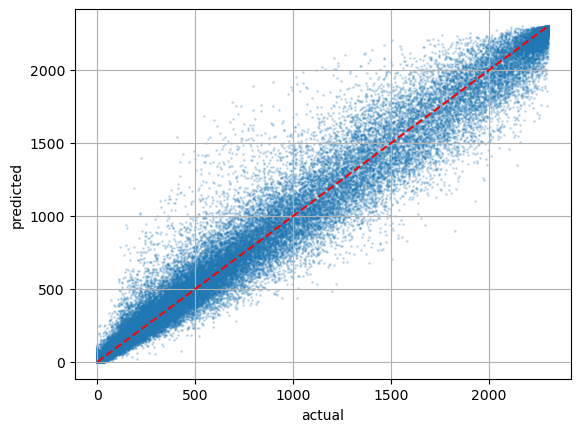

In [10]:
ax = pd.DataFrame({"predicted": y_pred, "actual": y_test}).plot.scatter(
    x="actual", y="predicted", s=1, alpha=0.2, grid=True
)
ax.plot([0, y_test.max()], [0, y_test.max()], "--r");  # adding red 1-to-1 line

# Predicting on submission data

In [11]:
X_submission = pd.read_parquet(submission_data_fpath).set_index("id")
X_submission.head(3)

,TimeStamp_StartFormat,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,...,ERA5_dew_point_2m,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,is_valid
id,,,,,,,,,,,,,,,,,,,,,
0,2020-01-01 00:00:00+00:00,11.16164,10.88820,11.86938,11.86918,11.67452,8.30,7.78,9.75,9.13,...,-2.408,0.0,994.515015,18.0,4.808326,9.484725,224.999893,227.563812,9.7,True
1,2020-01-01 00:10:00+00:00,11.30721,10.86559,12.97147,12.50372,11.38912,7.88,6.94,10.07,9.44,...,1.592,0.0,1000.559082,95.0,2.785677,5.247857,201.037582,210.963684,4.4,True
2,2020-01-01 00:20:00+00:00,11.27332,10.89379,12.21393,12.14904,11.12704,8.50,6.94,9.65,9.96,...,4.012,0.0,989.992554,68.0,5.803448,9.226592,271.974884,274.350983,11.1,True


In [12]:
submission_predictions = simple_model.predict(X_submission)

# Exporting the prediciton for submission
The expected output format of the submission is a csv table like the following:
```csv
id,prediction
0,123.45
1,6789.0
...
```

**NOTE**:
- the ***first column*** need to be a the unique identifier called ***id***.
- there must be **no nulls/NaN values** in the data

In [13]:
output_fpath = (OUTPUT_DIR / "sample_model_submission.csv").as_posix()

(submission_predictions.fillna(0).to_frame(name="prediction").to_csv(output_fpath))
print(f"Submission file saved to {output_fpath}")

Submission file saved to ~/Coding/hill-of-towie-wind-turbine/output/sample_model_submission.csv


In [14]:
!head -n 5 {output_fpath}

id,prediction
0,1790.092578125
1,1883.399609375
2,1777.3431884765625
3,1671.6916015625


## Optional: checking the submission file
This is an optional set of checks that should highlight common data issues before trying to submit the results to Kaggle.

In [15]:
_df = pd.read_csv(output_fpath)

# checking the columns are the expected ones
assert _df.columns.to_list() == ["id", "prediction"], (
    f'Expected columns ["id", "prediction"], found: {_df.columns.to_list()}'
)

# checking no nulls in the data
assert _df.isna().sum().sum() == 0, "There are NA values in the data!"

# checking the row ids are unique and within expected range
duplicated_ids = _df["id"].duplicated()
assert not duplicated_ids.any(), f"There are duplicated ids: {_df['id'][duplicated_ids].values}"
invalid_ids = set(_df["id"].unique()) - set(range(52704))
assert not invalid_ids, f"The following row IDs are not within the expected ones: {invalid_ids}"